# 🧠 Akbank Derin Öğrenme Bootcamp: Yeni Nesil Proje Kampı

## Projenin Amacı:
Bu projede, **CNN (Convolutional Neural Network)** mimarisi kullanılarak bir derin öğrenme projesi geliştirilmesi beklenmektedir.
Bu poroje sayesinde kişiye derin öğrenme alanında **görüntü sınıflandırması, veri analizi, model geliştirme, değerlendirme ve yorumlama** konularında pratik deneyim kazandırılması amaçlanmaktadır. 

## Projenin Konusu:
CNN kullanarak beyin tümörü sınıflandırılması yapılması heseflenmektedir.

## Veri Seti Hakkındda:
Bu veri seti toplamda 7023 insan beyin MRI görüntüsünden oluşmaktadır ve dört ayrı sınıfa ayrılmıştır. Veri seti, beyin tümörleri ve bunların sınıflandırılması üzerinde çalışılması için hazırlanmıştır. Bu dört sınıf şu şekildedir:

**Glioma:** Glial hücrelerde oluşan kanserli beyin tümörleri.

**Meningioma:** Meninkslerden kaynaklanan iyi huylu (kanserli olmayan) tümörler.

**Pituitary:** Hipofiz bezini etkileyen, kanserli veya kanserli olmayan tümörler.

**No Tumor:** Tümör bulunmayan, normal beyin taramaları.


In [1]:
# Kütüphanelerin İçe Aktarılması
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, regularizers, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Keras Tuner
import keras_tuner as kt
import warnings
warnings.filterwarnings('ignore')
print(" Tüm kütüphaneler başarıyla yüklendi!")

2025-09-26 19:40:04.586293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758915604.795825      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758915604.853528      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 Tüm kütüphaneler başarıyla yüklendi!


In [2]:
# Veri Setinin Kaggle Ortamından Çekilmesi
USER_PATH = r"/kaggle/input/brain-tumor-mri-dataset"
train_dir = USER_PATH + r'/Training/'
test_dir = USER_PATH + r'/Testing/'

class_names = sorted(os.listdir(train_dir))
N_TYPES = len(class_names)
IMG_SIZE = 128
BATCH_SIZE = 32
SEED = 1


## ✍️ Veri Önişleme
Bu kod parçacığında, görüntü (resim) verileriyle çalışan bir derin öğrenme modelinin eğitiminde kullanılan veri ön işleme adımlarına odaklanılmıştır. 
Keras'ın **ImageDataGenerator**'ı ile veri çoğaltma (data augmentation) işlemi uygulanıyor. Eğitim verileri üzerinde döndürme, yakınlaştırma, kaydırma, parlaklık değiştirme ve yatay/dikey çevirme gibi işlemlerle çeşitlilik kazandırılıyor. Böylece model daha fazla ve çeşitli örnekle eğitiliyor, aşırı öğrenme riski azalıyor.

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.1
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5143 images belonging to 4 classes.
Found 569 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


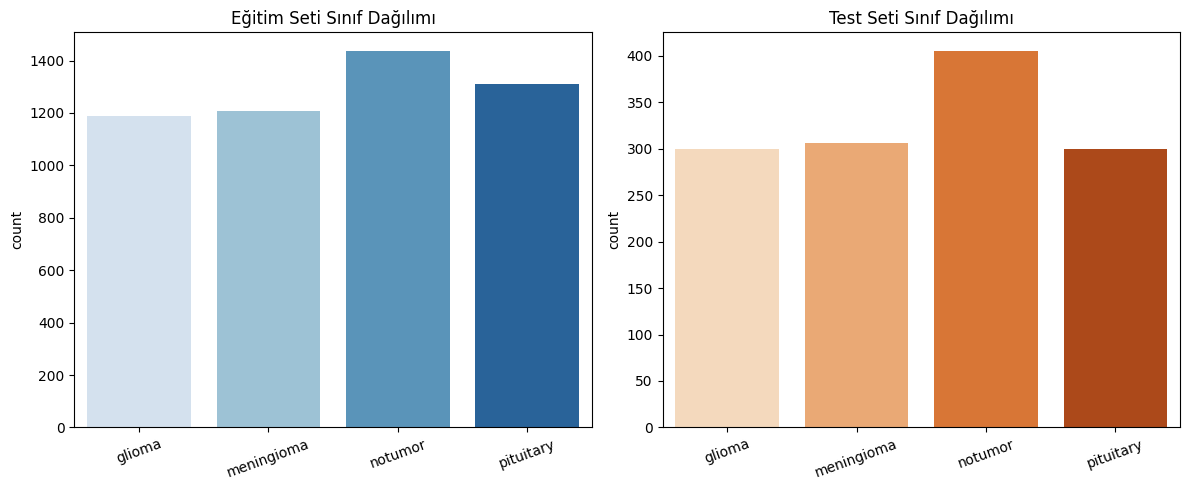

In [4]:
# Sınıflara Dağılım
train_labels = train_gen.classes
test_labels = test_gen.classes

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=pd.Series(train_labels), ax=axes[0], palette="Blues")
axes[0].set_title("Eğitim Seti Sınıf Dağılımı")
axes[0].set_xticks(range(len(class_names)))
axes[0].set_xticklabels(class_names, rotation=20)
sns.countplot(x=np.array(test_labels), ax=axes[1], palette="Oranges")
axes[1].set_title("Test Seti Sınıf Dağılımı")
axes[1].set_xticks(range(len(class_names)))
axes[1].set_xticklabels(class_names, rotation=20)
plt.tight_layout()
plt.show()

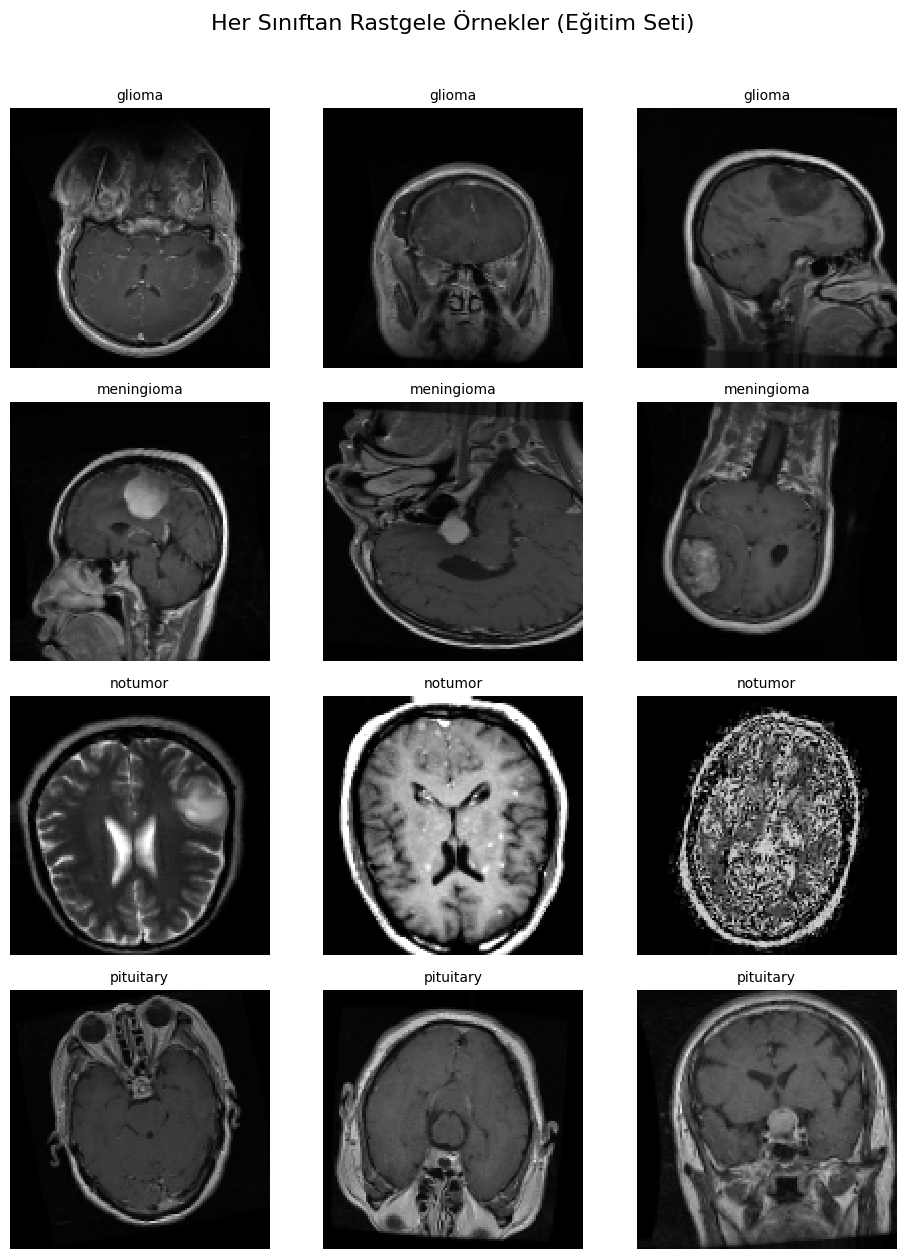

In [5]:
def plot_samples_per_class(
    train_gen,
    class_names,
    n_per_class=3,
    max_batches=20,
    seed=None,
    title="Her Sınıftan Rastgele Örnekler (Eğitim Seti)"
):
    rng = np.random.default_rng(seed)
    n_classes = len(class_names)

    # Görsel havuzu
    pool = {i: [] for i in range(n_classes)}

    batches_seen = 0
    while batches_seen < max_batches and any(len(pool[i]) < n_per_class for i in range(n_classes)):
        x_batch, y_batch = next(train_gen)
        batches_seen += 1

        if y_batch.ndim > 1 and y_batch.shape[1] > 1:
            labels = np.argmax(y_batch, axis=1)
        else:
            labels = y_batch.astype(int).ravel()

        for cls in range(n_classes):
            need = n_per_class - len(pool[cls])
            if need <= 0:
                continue
            idxs = np.where(labels == cls)[0]
            if len(idxs) == 0:
                continue
            pick = idxs if len(idxs) <= need else rng.choice(idxs, size=need, replace=False)
            for k in np.atleast_1d(pick):
                pool[cls].append(np.array(x_batch[k], copy=True))

    fig, axes = plt.subplots(n_classes, n_per_class, figsize=(n_per_class*3.2, n_classes*3.2))
    if n_classes == 1 and n_per_class == 1:
        axes = np.array([[axes]])
    elif n_classes == 1:
        axes = axes[np.newaxis, :]
    elif n_per_class == 1:
        axes = axes[:, np.newaxis]

    fig.suptitle(title, fontsize=16, y=0.98)

    for j in range(n_per_class):
        axes[0, j].set_title(f"Örnek {j+1}", fontsize=12, pad=8)

    for i, cls_name in enumerate(class_names):
        for j in range(n_per_class):
            ax = axes[i, j]
            ax.axis("off")

            if j < len(pool[i]):
                img = pool[i][j]
                if img.ndim == 3 and img.shape[-1] == 1:
                    ax.imshow(img.squeeze(-1), cmap="gray", interpolation="nearest")
                elif img.ndim == 2:
                    ax.imshow(img, cmap="gray", interpolation="nearest")
                else:
                    ax.imshow(img, interpolation="nearest")

                # Görselin üstüne sınıf adını yaz
                ax.set_title(f"{cls_name}", fontsize=10)
            else:
                ax.text(0.5, 0.5, "Yeterli örnek yok", ha="center", va="center", fontsize=10)

        axes[i, 0].set_ylabel(cls_name, fontsize=12, rotation=0, labelpad=40, va="center")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
plot_samples_per_class(train_gen, class_names, n_per_class=3, seed=42)

In [6]:
# Keras Tuner ile CNN Modelinin Oluşturulması

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_1', [3, 5]),
        activation='relu',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # 2. Conv block
    model.add(layers.Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice('kernel_2', [3, 5]),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # 3. Conv block (opsiyonel)
    if hp.Boolean('use_third_block'):
        model.add(layers.Conv2D(
            filters=hp.Int('filters_3', min_value=64, max_value=256, step=64),
            kernel_size=hp.Choice('kernel_3', [3, 5]),
            activation='relu',
            kernel_regularizer=regularizers.l2(0.001)
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(layers.Dense(N_TYPES, activation='softmax'))

    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [8]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=7, 
    restore_best_weights=True, 
    verbose=1,
    mode='min' # val_loss'u minimize etmeyi hedefler
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6, 
    verbose=1,
    mode='min'
)

#Keras Tuner ile Hipermetre Taraması
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=3,
    factor=3,
    directory='kt_dir_optimized', # Yeni bir dizin adı
    project_name='brain_tumor_cnn'
)

# Arama işlemini başlat
print("Hiperparametre arama işlemi başlıyor...")
tuner.search(
    train_gen,
    validation_data=val_gen,
    epochs=3 ,
    callbacks=[early_stop, reduce_lr]
)

# Arama sonuçlarının özetini görmek çok faydalıdır.
print("\nHiperparametre arama sonuçları:")
tuner.results_summary()

# En İyi Modelin Alınması ve Değerlendirilmesi

print("\nArama sonucunda bulunan en iyi model alınıyor...")
best_model = tuner.get_best_models(num_models=1)[0]

# En iyi hiperparametreleri de alıp yazdıralım
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nEn iyi hiperparametreler:")
for hp, value in best_hps.values.items():
    print(f"- {hp}: {value}")

print("\nEn iyi model test verisi ile değerlendiriliyor:")
test_loss, test_acc = best_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

Trial 6 Complete [00h 01m 53s]
val_accuracy: 0.4815465807914734

Best val_accuracy So Far: 0.4815465807914734
Total elapsed time: 00h 08m 03s

Hiperparametre arama sonuçları:
Results summary
Results in kt_dir_optimized/brain_tumor_cnn
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0005 summary
Hyperparameters:
filters_1: 32
kernel_1: 3
filters_2: 256
kernel_2: 3
use_third_block: False
dense_units: 512
dropout: 0.4
learning_rate: 0.0009973637481625263
filters_3: 192
kernel_3: 5
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.4815465807914734

Trial 0004 summary
Hyperparameters:
filters_1: 96
kernel_1: 5
filters_2: 192
kernel_2: 3
use_third_block: False
dense_units: 384
dropout: 0.4
learning_rate: 0.0001224029351440242
filters_3: 256
kernel_3: 3
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.35149383544921875

Trial 0003 summary
Hyperparameters:
filters_1: 96
kernel_1: 5
filters_2: 64
kernel_2


En iyi hiperparametreler ile model sıfırdan oluşturulup yeniden eğitiliyor...
Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 35s 219ms/step - accuracy: 0.7587 - loss: 0.7507 - val_accuracy: 0.4763 - val_loss: 2.3485 - learning_rate: 9.9736e-04
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 32s 201ms/step - accuracy: 0.7755 - loss: 0.7090 - val_accuracy: 0.7241 - val_loss: 0.8228 - learning_rate: 9.9736e-04
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 32s 199ms/step - accuracy: 0.7883 - loss: 0.6515 - val_accuracy: 0.7540 - val_loss: 0.7532 - learning_rate: 9.9736e-04
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 33s 204ms/step - accuracy: 0.8106 - loss: 0.6009 - val_accuracy: 0.7680 - val_loss: 0.7123 - learning_rate: 9.9736e-04
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 32s 201ms/step - accuracy: 0.8299 - loss: 0.5482 - val_accuracy: 0.5589 - val_loss: 1.3725 - learning_rate: 9.9736e-04
Restoring model weights from the end of the best epoch: 4.

Eğitim süreci görselleştiriliyor...


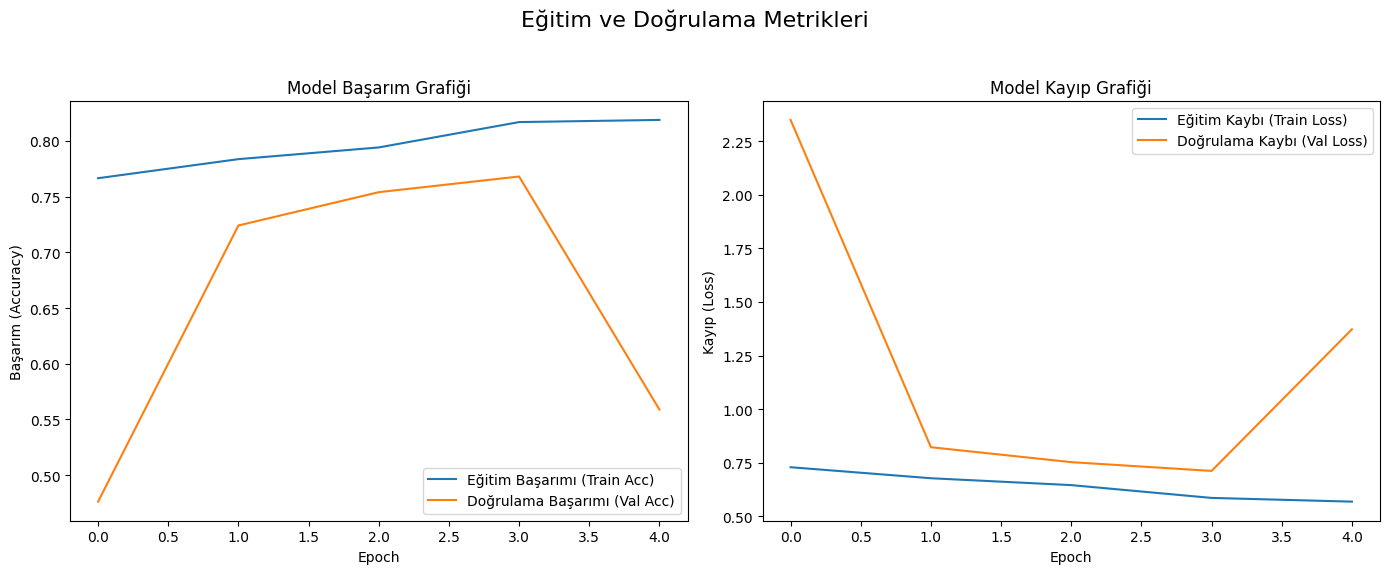

In [11]:
print("\nEn iyi hiperparametreler ile model sıfırdan oluşturulup yeniden eğitiliyor...")

history = best_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5, # Daha uzun bir eğitim
    callbacks=[early_stop, reduce_lr]
)

print("\nEğitim süreci görselleştiriliyor...")
plt.figure(figsize=(14, 6))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Başarımı (Train Acc)')
plt.plot(history.history['val_accuracy'], label='Doğrulama Başarımı (Val Acc)')
plt.title('Model Başarım Grafiği')
plt.ylabel('Başarım (Accuracy)')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı (Train Loss)')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı (Val Loss)')
plt.title('Model Kayıp Grafiği')
plt.ylabel('Kayıp (Loss)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.suptitle('Eğitim ve Doğrulama Metrikleri', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()